Clone the GitHub repository

In [ ]:
!git clone https://github.com/SWastling/mese_cpmg_t2_mle
!pip install pytest pytest-sugar coverage
%cd mese_cpmg_t2_mle

Run the unit tests of gf.py, nll.py and rftools.py and check they cover all the code

In [130]:
!coverage run -m pytest
!coverage report -m

Test session starts (platform: linux, Python 3.10.12, pytest 7.4.4, pytest-sugar 1.0.0)
rootdir: /content/mese_cpmg_t2_mle
plugins: sugar-1.0.0, typeguard-4.3.0, anyio-3.7.1
collected 25 items                                                                                 

 test_gf.py ✓✓✓✓                                                                      16% █▋        
 test_nll.py ✓✓                                                                       24% ██▌       
 test_rftools.py ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓                                                 100% ██████████

Results (1.43s):
      25 passed
Name              Stmts   Miss  Cover   Missing
-----------------------------------------------
gf.py                26      0   100%
nll.py               15      0   100%
rftools.py           72      0   100%
test_gf.py           47      0   100%
test_nll.py          13      0   100%
test_rftools.py     129      0   100%
-----------------------------------------------
TOTAL           

Import the required libraries

In [131]:
import numpy as np
import matplotlib.pyplot as plt

import gf
import nll
import rftools

Define a function to generate an exponential decay for comparison with GF



In [132]:
def exp_decay(A, n, tau, t2, returnte0=False, debug=False):
    """
    :param A: signal scale factor (i.e. signal at TE=0 is A)
    :type A: float
    :param n: number of echoes
    :type n: int
    :param tau: echo spacing in s
    :type tau: float
    :param t2: transverse relaxtion time in s
    :type t2: float
    :param returnte0: include signal at TE=0 in output
    :type returnte0: bool
    :param debug: show output as plot if true
    :type debug: bool
    :return: signal as a function of echo time
    :rtype: np.ndarray[float]
    """


    if returnte0:
        te = np.arange(0, n + 1) * tau
    else:
        te = np.arange(1, n + 1) * tau

    s = A * np.exp (- te / t2)

    if debug:
        plt.plot(te, s)
        plt.title('exp_decay output')
        plt.xlabel('Echo time (s)')
        plt.ylabel('Signal (a.u.)')

    return s

Check implemenation by re-creating Figure 1 (a) and (b) from Petrovic et. al. 2015 which shows on the signal decay curve of both:
- refocusing pulses with flip-angles less than 180 degrees
- imperfect slice profiles resulting from Gaussian RF pulses

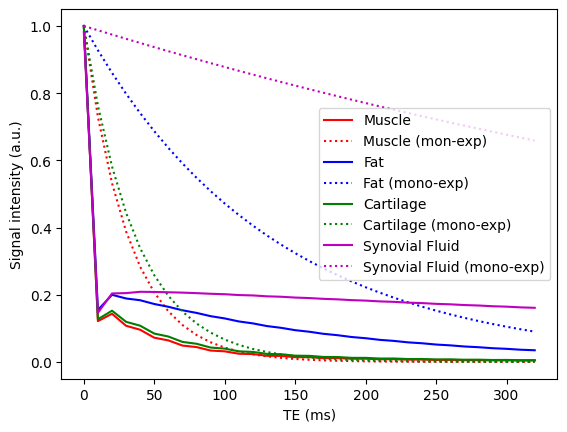

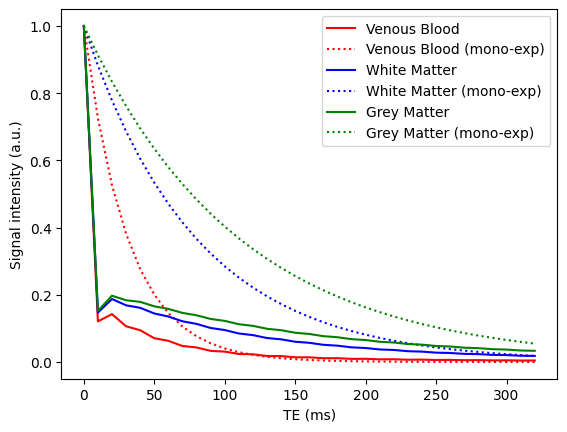

In [133]:
Q = 90 # number of spatial positions across slice
B1 = 1 # B1 scaling to account for B1 inhomogeniety
n = 32 # number of echoes
K = 257 # number of points to sample generating function
fa_ex = np.ones(Q) * np.pi / 2 # ideal excitation flip angles in radians (sampled at Q points like refocussing pulse below)
tau = 10E-3 # echo spacing in s

# Gaussian rf pulse with 144 degree flip angle (with 128 points in time domain)
slthick = 5E-3 # 5 mm slice
spat_pos = rftools.spatial_positions(slthick, 2, Q)
tbw_ref = 4
rf_ref = rftools.rf_gaussian(144 * np.pi / 180, tbw_ref, 128)
fa_ref = rftools.rf2profile('angle', rf_ref, tbw_ref, spat_pos, slthick)

# longitudinal relaxation times (at 3T) in s
T1_Muscle = 1.42 # Gold et al AJR:183 (2004) as referenced by Petrovic
T1_Fat = 0.371 # Gold et al AJR:183 (2004) as referenced by Petrovic
T1_Cartilage = 1.24 # Gold et al AJR:183 (2004) as referenced by Petrovic
T1_SynovialFluid = 3.62 # Gold et al AJR:183 (2004) as referenced by Petrovic
T1_VenousBlood = 1.584 # Lu et al MRM 52:679 – 682 (2004)
T1_WhiteMatter = 0.832 # Wansapura et al JMRI 9:531–538 (1999) as referenced by Petrovic
T1_GreyMatter = 1.331 # Wansapura et al JMRI 9:531–538 (1999) as referenced by Petrovic

# transverse relaxation times (at 3T) in s
T2_Muscle = 31.7E-3 # Gold et al AJR:183 (2004) as referenced by Petrovic
T2_Fat = 133E-3 # Gold et al AJR:183 (2004) as referenced by Petrovic
T2_Cartilage = 36.9E-3 # Gold et al AJR:183 (2004) as referenced by Petrovic
T2_SynovialFluid = 767E-3 # Gold et al AJR:183 (2004) as referenced by Petrovic
T2_VenousBlood = 31.1E-3 # Zhao et al MRM 58:592–596 (2007)
T2_WhiteMatter = 79.6E-3 # Wansapura et al JMRI 9:531–538 (1999) as referenced by Petrovic
T2_GreyMatter = 110E-3 # Wansapura et al JMRI 9:531–538 (1999) as referenced by Petrovic

# array of echo times for plots
te = 1000 * np.arange(0, n + 1) * tau

s_muscle = gf.GF(1, K, T1_Muscle, T2_Muscle, tau, n, fa_ex, fa_ref, 1, True)
s_fat = gf.GF(1, K, T1_Fat, T2_Fat, tau, n, fa_ex, fa_ref, 1, True)
s_cartilage = gf.GF(1, K, T1_Cartilage, T2_Cartilage, tau, n, fa_ex, fa_ref, 1, True)
s_sf = gf.GF(1, K, T1_SynovialFluid, T2_SynovialFluid, tau, n, fa_ex, fa_ref, 1, True)
s_vb = gf.GF(1, K, T1_VenousBlood, T2_VenousBlood, tau, n, fa_ex, fa_ref, 1, True)
s_wm = gf.GF(1, K, T1_WhiteMatter, T2_WhiteMatter, tau, n, fa_ex, fa_ref, 1, True)
s_gm = gf.GF(1, K, T1_GreyMatter, T2_GreyMatter, tau, n, fa_ex, fa_ref, 1, True)

s_muscle_exp = exp_decay(1, n, tau, T2_Muscle, True)
s_fat_exp = exp_decay(1, n, tau, T2_Fat, True)
s_cartilage_exp = exp_decay(1, n, tau, T2_Cartilage, True)
s_sf_exp = exp_decay(1, n, tau, T2_SynovialFluid, True)
s_vb_exp = exp_decay(1, n, tau, T2_VenousBlood, True)
s_wm_exp = exp_decay(1, n, tau, T2_WhiteMatter, True)
s_gm_exp = exp_decay(1, n, tau, T2_GreyMatter, True)

plt.plot(te, s_muscle, 'r',
         te, s_muscle_exp, 'r:',
         te, s_fat, 'b',
         te, s_fat_exp, ':b',
         te, s_cartilage, 'g',
         te, s_cartilage_exp, 'g:',
         te, s_sf, 'm',
         te, s_sf_exp, ':m')
plt.xlabel('TE (ms)')
plt.ylabel('Signal intensity (a.u.)')
plt.legend(['Muscle',
            'Muscle (mon-exp)',
            'Fat',
            'Fat (mono-exp)',
            'Cartilage',
            'Cartilage (mono-exp)',
            'Synovial Fluid',
            'Synovial Fluid (mono-exp)'])
plt.show()

plt.plot(te, s_vb, 'r',
         te, s_vb_exp,':r',
         te, s_wm, 'b',
         te, s_wm_exp , ':b',
         te, s_gm, 'g',
         te, s_gm_exp, ':g')
plt.xlabel('TE (ms)')
plt.ylabel('Signal intensity (a.u.)')
plt.legend(['Venous Blood',
            'Venous Blood (mono-exp)',
            'White Matter',
            'White Matter (mono-exp)',
            'Grey Matter',
            'Grey Matter (mono-exp)'])
plt.show()

Check implemenation by re-creating Figure 1 (c) from Petrovic et. al. 2015 which shows the impact on the signal decay curve of the refocusing flip-angle:

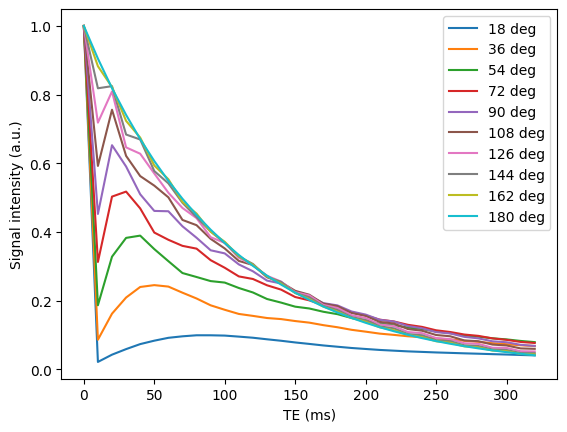

In [134]:
B1 = 1 # B1 scaling to account for B1 inhomogeniety
n = 32 # number of echoes
K = 257 # number of points to sample generating function
fa_ex = np.ones(Q) * np.pi / 2 # ideal excitation flip angles in radians (sampled at Q points like refocussing pulse below)
tau = 10E-3 # echo spacing in s

fa_ex = np.pi / 2 # ideal excitation
fa_ref_deg = np.array([18, 36, 54, 72, 90, 108, 126, 144, 162, 180])
fa_ref = np.array([18, 36, 54, 72, 90, 108, 126, 144, 162, 180]) * np.pi / 180 # refocussing


# array of echo times for plots
te = 1000 * np.arange(0, n + 1) * tau
for fa_ref_deg_el in fa_ref_deg:
  s = gf.GF(1, K, 1, 0.1, tau, n, fa_ex, fa_ref_deg_el * np.pi / 180, 1, True)
  plt.plot(te, s, label=str(fa_ref_deg_el) + ' deg')

plt.xlabel('TE (ms)')
plt.ylabel('Signal intensity (a.u.)')
plt.legend()
plt.show()


Check implemenation by re-creating Figure 1 (d) from Petrovic et. al. 2015 which shows the impact on the signal decay curve of both:
- the RF refocusing pulse shape
- refocusing pulses with flip-angles less than 180 degrees

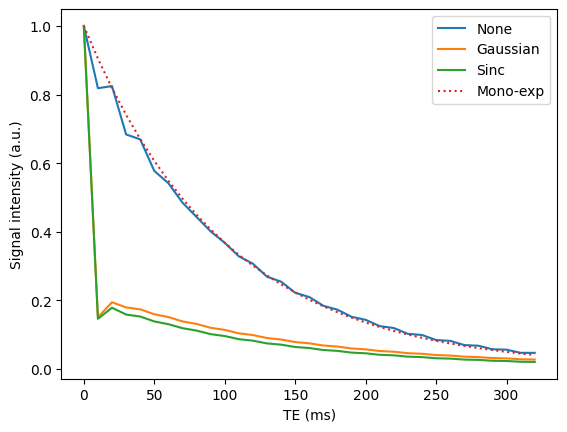

In [135]:
Q = 90 # number of spatial positions across slice
B1 = 1 # B1 scaling to account for B1 inhomogeniety
n = 32 # number of echoes
K = 257 # number of points to sample generating function
fa_ex = np.ones(Q) * np.pi / 2 # ideal excitation flip angles in radians (sampled at Q points like refocussing pulse below)
fa_ref_planned = 144 * np.pi / 180
tau = 10E-3 # echo spacing in s
t1 = 1
t2 = 0.1

slthick = 5E-3 # 5 mm slice
spat_pos = rftools.spatial_positions(slthick, 2, Q)

# Ideal refocussing
fa_ref_ideal = np.ones(Q) * fa_ref_planned

# Gaussian rf pulse with 144 degree flip angle (with 128 points in time domain)
tbw_ref_g = 4
rf_ref_g = rftools.rf_gaussian(fa_ref_planned, tbw_ref_g, 128)
fa_ref_g = rftools.rf2profile('angle', rf_ref_g, tbw_ref_g, spat_pos, slthick)

# Sinc rf pulse
tbw_ref_s = 4
rf_ref_s = rftools.rf_sinc(fa_ref_planned, tbw_ref_s, 0.46, 128)
fa_ref_s = rftools.rf2profile('angle', rf_ref_s, tbw_ref_s, spat_pos, slthick)

s_gf_ideal = gf.GF(1, K, t1, t2, tau, n, fa_ex, fa_ref_ideal, 1, True)
s_gf_gaussian = gf.GF(1, K, t1, t2, tau, n, fa_ex, fa_ref_g, 1, True)
s_gf_sinc = gf.GF(1, K, t1, t2, tau, n, fa_ex, fa_ref_s, 1, True)

# Exponential decay
s_exp = exp_decay(1, n, tau, t2, True)

# array of echo times for plots
te = 1000 * np.arange(0, n + 1) * tau

plt.plot(te, s_gf_ideal)
plt.plot(te, s_gf_gaussian)
plt.plot(te, s_gf_sinc)
plt.plot(te, s_exp, ':')


plt.xlabel('TE (ms)')
plt.ylabel('Signal intensity (a.u.)')
plt.legend(['None', 'Gaussian', 'Sinc','Mono-exp'])
plt.show()

Check implemenation by re-creating Figure 1 (e) from Petrovic et. al. 2015 which  shows the impact of the T1 on the signal decay curve when the refocusing flip angle is less than 180 degrees (specifically 90 degrees):

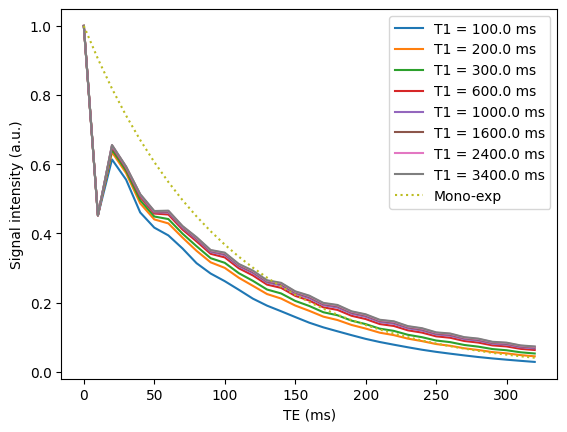

In [136]:
B1 = 1 # B1 scaling to account for B1 inhomogeniety
n = 32 # number of echoes
K = 257 # number of points to sample generating function
fa_ex = np.ones(Q) * np.pi / 2 # ideal excitation flip angles in radians (sampled at Q points like refocussing pulse below)
tau = 10E-3 # echo spacing in s

fa_ex = np.pi / 2 # excitation
fa_ref = np.pi / 2 # refocussing (set deliberately to 90 degrees)

t1 = np.array([0.1, 0.2, 0.3, 0.6, 1, 1.6, 2.4, 3.4])
t2 = 0.1

# array of echo times for plots
te = 1000 * np.arange(0, n + 1) * tau
for idx, t1_el in enumerate(t1):
  s_gf = gf.GF(1, K, t1_el, t2, tau, n, fa_ex, fa_ref, 1, True)
  plt.plot(te, s_gf, label='T1 = ' + str(1000 * t1_el) + ' ms')

s_exp = exp_decay(1, n, tau, t2, True)
plt.plot(te, s_exp, ':', label='Mono-exp')

plt.xlabel('TE (ms)')
plt.ylabel('Signal intensity (a.u.)')
plt.legend()
plt.show()

Check implemenation by re-creating Figure 1 (f) from Petrovic et. al. 2015 which shows the impact of the T2 on the signal decay curve when the refocusing flip angle is less than 180 degrees (specifically 90 degrees).

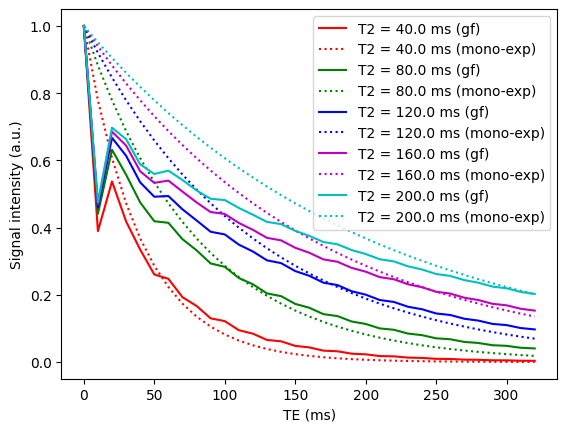

In [137]:
B1 = 1 # B1 scaling to account for B1 inhomogeniety
n = 32 # number of echoes
K = 257 # number of points to sample generating function
fa_ex = np.ones(Q) * np.pi / 2 # ideal excitation flip angles in radians (sampled at Q points like refocussing pulse below)
tau = 10E-3 # echo spacing in s

fa_ex = np.pi / 2 # excitation
fa_ref = np.pi / 2 # refocussing (set deliberately to 90 degrees)

t2 = np.array([0.04, 0.08, 0.12, 0.16, 0.2])

# array of echo times for plots
colours = ['r', 'g', 'b', 'm', 'c']

te = 1000 * np.arange(0, n + 1) * tau
for idx, t2_el in enumerate(t2):
  s_gf = gf.GF(1, K, 1, t2_el, tau, n, fa_ex, fa_ref, 1, True)
  plt.plot(te, s_gf, colours[idx], label='T2 = ' + str(1000 * t2_el) + ' ms (gf)')
  s_exp = exp_decay(1, n, tau, t2_el, True)
  plt.plot(te, s_exp, colours[idx] + ':', label='T2 = ' + str(1000 * t2_el) + ' ms (mono-exp)')

plt.xlabel('TE (ms)')
plt.ylabel('Signal intensity (a.u.)')
plt.legend()
plt.show()

Demonstrate MLE fitting to simulated data

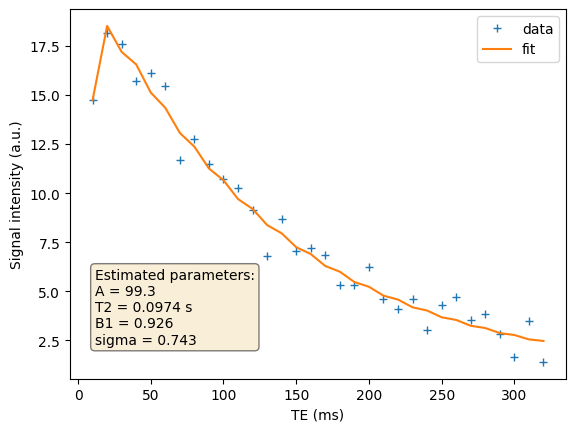

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 35.8177809590107
        x: [ 9.927e+01  9.741e-02  9.260e-01  7.430e-01]
      nit: 37
      jac: [ 3.055e-05 -1.506e-02 -1.622e-03 -2.096e-04]
     nfev: 315
     njev: 63
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


In [139]:
import matplotlib.pyplot as plt
from scipy import optimize

import gf
import nll
import rftools

A = 100 # signal at TE = 0 ms
Q = 90 # number of spatial positions across slice
B1 = 0.9 # B1 scaling to account for B1 inhomogeniety
n = 32 # number of echoes
K = 257 # number of points to sample generating function
tau = 10E-3 # echo spacing in s
t1 = 1 # longitudinal relaxation time in s
t2 = 0.1 # transverse relaxation time in s

slthick = 5E-3 # 5 mm slice
spat_pos = rftools.spatial_positions(slthick, 2, Q)

# ideal excitation flip angles in radians (sampled at Q points like refocussing pulse below)
fa_ex = np.ones(Q) * np.pi / 2

# Gaussian rf pulse
fa_ref_planned = np.pi
tbw_ref = 4
rf_ref = rftools.rf_gaussian(fa_ref_planned, tbw_ref, 128)
fa_ref = rftools.rf2profile('angle', rf_ref, tbw_ref, spat_pos, slthick)

s = gf.GF(A, K, t1, t2, tau, n, fa_ex, fa_ref, B1, False, False)

# Add Gaussian noise to in-phase and quadrature channels
sigma = 0.75
noise_r = sigma * np.random.randn(n)  # in-phase noise
noise_i = sigma * np.random.randn(n)  # quadrature noise
s_meas = np.sqrt((s + noise_r) ** 2 + noise_i **2 )

# x0 = [A0, t20, b10, sigma0] i.e. the initial guesses of A, t2, b1 and sigma
x0 = [50, 0.2, 1, 0.1]
x_bounds = [(1, 200),
          (0.01, 1),
          (0.1, 1),
          (0.01, 1)]

# Minimize the negative log likelihood
result = optimize.minimize(nll.nll_gf, x0, args=(K, t1, tau, n, fa_ex, fa_ref, s_meas), bounds=x_bounds)

# Calculate the signal using the estimated parameters
A_mle = result.x[0]
t2_mle = result.x[1]
b1_mle = result.x[2]
sigma_mle = result.x[3]
s_fit = gf.GF(A_mle, K, t1, t2_mle, tau, n, fa_ex, fa_ref, b1_mle)

# Plot the data and fitted model
te = 1000 * np.arange(1, n + 1) * tau
plt.plot(te, s_meas, '+', te, s_fit)
plt.xlabel('TE (ms)')
plt.ylabel('Signal intensity (a.u.)')
plt.legend(['data', 'fit'])
textstr = f'Estimated parameters:\nA = {A_mle:.3g}\nT2 = {t2_mle:.3g} s\nB1 = {b1_mle:.3g}\nsigma = {sigma_mle:.3g}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.3, textstr, fontsize=10, transform=plt.gca().transAxes, verticalalignment='top', bbox=props)
plt.show()

print(result)